# Simulations for ABLE

Incorporating an explicit water vapor number concentration value instead of arbitrary "aerosol" concentration value that would produce fluxes ABLE expects...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path
import yaml

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/../utils'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data_utils import set_binwidth, load_config
from cloud_utils import gen_cloud

eps = sys.float_info.epsilon

I will start by forward modeling the received power from a scene that contains air ($N_2$ and $O_2$) and water vapor molecular constituents.

$$P(\lambda,R) = P_0(\lambda)\frac{c\Delta t}{2}\frac{A}{R^2}\eta(\lambda) G(R)\beta_{mol}(\lambda,R)e^{-2\tau_{mol}(\lambda,R)}e^{-2\tau_{WV}(\lambda,R)}+P_B(\lambda)$$
where $mol$ represents air molecules and $WV$ represents water vapor molecules.
$$\tau(\lambda, R)\triangleq\int_{0}^{R}\alpha(\lambda, R')dR'$$
$$\alpha(\lambda, R)\triangleq\sigma_{abs}(\lambda)n(R)$$
$$\Delta\tau\triangleq\tau(\lambda_1, R)-\tau(\lambda_2, R)=[\sigma_{abs}(\lambda_1)-\sigma_{abs}(\lambda_2)]\int_0^{R}n(R')dR'=\Delta\sigma_{abs}(\lambda_1,\lambda_2)\int_0^Rn(R')dR'$$

$$\frac{P(\lambda_1, R)-P_B(\lambda_1)}{P(\lambda_2, R)-P_B(\lambda_2)}=\frac{P_0(\lambda_1)\eta(\lambda_1)}{P_0(\lambda_2)\eta(\lambda_2)}\frac{\beta_{mol}(\lambda_1, R)}{\beta_{mol}(\lambda_2, R)}\exp\left(-2\Delta\tau_{mol}[\lambda_1, \lambda_2, R]\right)\exp\left(-2\Delta\tau_{WV}[\lambda_1, \lambda_2, R]\right)$$

If we choose $\lambda_1$ and $\lambda_2$ such that $P_0(\lambda_1)=P_0(\lambda_2)$ and $\eta(\lambda_1)=\eta(\lambda_2)$, and $\beta_{mol}(\lambda_1)=\beta_{mol}(\lambda_2)$ and $\Delta\tau_{mol}=0$, then
$$\Delta\tau_{WV}(\lambda_1,\lambda_2,R)=-\frac{1}{2}\ln\left[\frac{P(\lambda_1,R)-P_B(\lambda_1)}{P(\lambda_2,R)-P_B(\lambda_2)}\right]$$
This occurs for on- and off-line wavelengths that experience strong and weak absorption for water vapor. We can then back out number concentration:
$$n_{WV}(R)=\frac{1}{2\Delta\sigma_{abs}(\lambda_1,\lambda_2)}\frac{d}{dR}\ln\left(\frac{P(\lambda_2,R)-P_B(\lambda_2)}{P(\lambda_1,R)-P_B(\lambda_1)}\right)$$

This is the continuous formulation. For the discrete case ("forward difference approximation"), this becomes
$$n_{WV}(R)=\frac{1}{2\Delta\sigma_{abs}(\lambda_1,\lambda_2)\Delta R}\ln\left(\frac{P(\lambda_2,R+\Delta R)-P_B(\lambda_2)}{P(\lambda_1,R+\Delta R)-P_B(\lambda_1)}\frac{P(\lambda_1,R)-P_B(\lambda_1)}{P(\lambda_2,R)-P_B(\lambda_2)}\right)$$

This relies on $\Delta R$ being small with respect to changes in the constituent profile. This can be problematic near sharp gradients, like clouds...

In [3]:
config_path = cwd + r'\..\config'
config = load_config(config_path + r'\sim_ABLE_DIAL_config.yaml')

In [4]:
# CONSTANTS
c = config['constants']['c']  # [m/s] speed of light
k_B = config['constants']['k_B']  # [m^2 kg s-2 K-1] Boltzmann constant
g_0 = config['constants']['g_0']  # [m s-2] gravity
M_air = config['constants']['M_air']  # [g/mol] Molar mass of air
R_0 = config['constants']['R_0']  # [J/mol/K] Avogadro's number
h = config['constants']['h']  # [J s] Planck's constant
G = config['constants']['G']  # [N m2 kg-2] Gravitational constant
M_E = config['constants']['M_E']  # [kg] Earth's mass

# PARAMETERS

# Thermodynamics
L = config['params']['L']  # [K/km] Lapse rate for Denver
P_0 = config['params']['P_0']  # [mbar] Typical absolute pressure Denver
T_0 = config['params']['T_0']  # [K] Typical 70F temperature for Denver

# Laser params
lamb_base = config['params']['lamb_base']  # [m] laser wavelength
freq_off = config['params']['freq_off']  # [Hz] offline frequency offset
freq_on = config['params']['freq_on']  # [Hz] online frequency offset
E_L = config['params']['E_L']  # [W] laser pulse energy
dt_L = config['params']['dt_L']  # [s] laser pulse FWHM
f_L = config['params']['f_L']  # [Hz] rep rate

# Receiver specs
D = config['params']['D']  # [in] outer diameter of scope
d = config['params']['d']  # [in] inner diameter of scope
R_eta = config['params']['R_eta']  # Receiver efficiency (excluding detector)
eta_QE = config['params']['eta_QE']  # Detector quantum efficiency
loss = config['params']['loss']  # Unaccounted loss term
tD = config['params']['tD']  # [s]  # SPAD deadtime
dt_ABLE = config['params']['dt_ABLE']  # [s] native clock resolution of ABLE

# Signal
N_B = config['params']['N_B']  # Number of background photons
hres_ABLE = config['params']['hres_ABLE']  # [m] horizontal resolution ABLE
vres_ABLE = config['params']['vres_ABLE']  # [m] range resolution ABLE

# Satellite
orbit = config['params']['orbit']  # [m] orbit 

Simulate return in troposphere (really PBL) from nadir-pointing satellite using CALIPSO orbit. I'm interested in 0 - 5 km above the surface. Start by assuming flat surface at 0 km altitude.

In [5]:
# Generate range grid
dalt = c * dt_ABLE / 2  # [m] range resolution
alt = np.arange(0, 5000, dalt)[::-1]  # [m] altitudes I'm interested

R = (orbit - alt)  # [m] range from satellite

# Calculate Temperature and Pressure
temp = T_0 - L/1000*alt  # [K]
C_g = g_0 * M_air / R_0 / L
pressure = P_0 * (temp/T_0)**C_g  # [mbar]

# Air molecular scattering coefficients
beta_mol = 2.938e-32 * pressure/temp * lamb_base**(-4.0117)  # [m-1 sr-1]
alpha_mol = 8*np.pi/3 * beta_mol  # [m-1]

# Telescope parameters
A = np.pi/4*(D**2-d**2)  # [in^2]
A *= (0.0254**2)  # [m^2] Area

# Geometric overlap
G_overlap = 1  # overlap is unity at far-field

dR = dalt  # [m] range resolution

# Number of transmitted photons per shot
# (assume number of transmitted photons is equal across shot-to-shot tuning)
N_L = E_L/h/c*lamb_base 

# Receiver efficiency
eta_sys = R_eta * eta_QE / loss  # efficiency of receiver, detector, and unaccounted losses

# Spacecraft
sc_vel = np.sqrt(G*M_E/orbit)  # [m/s] spacecraft velocity

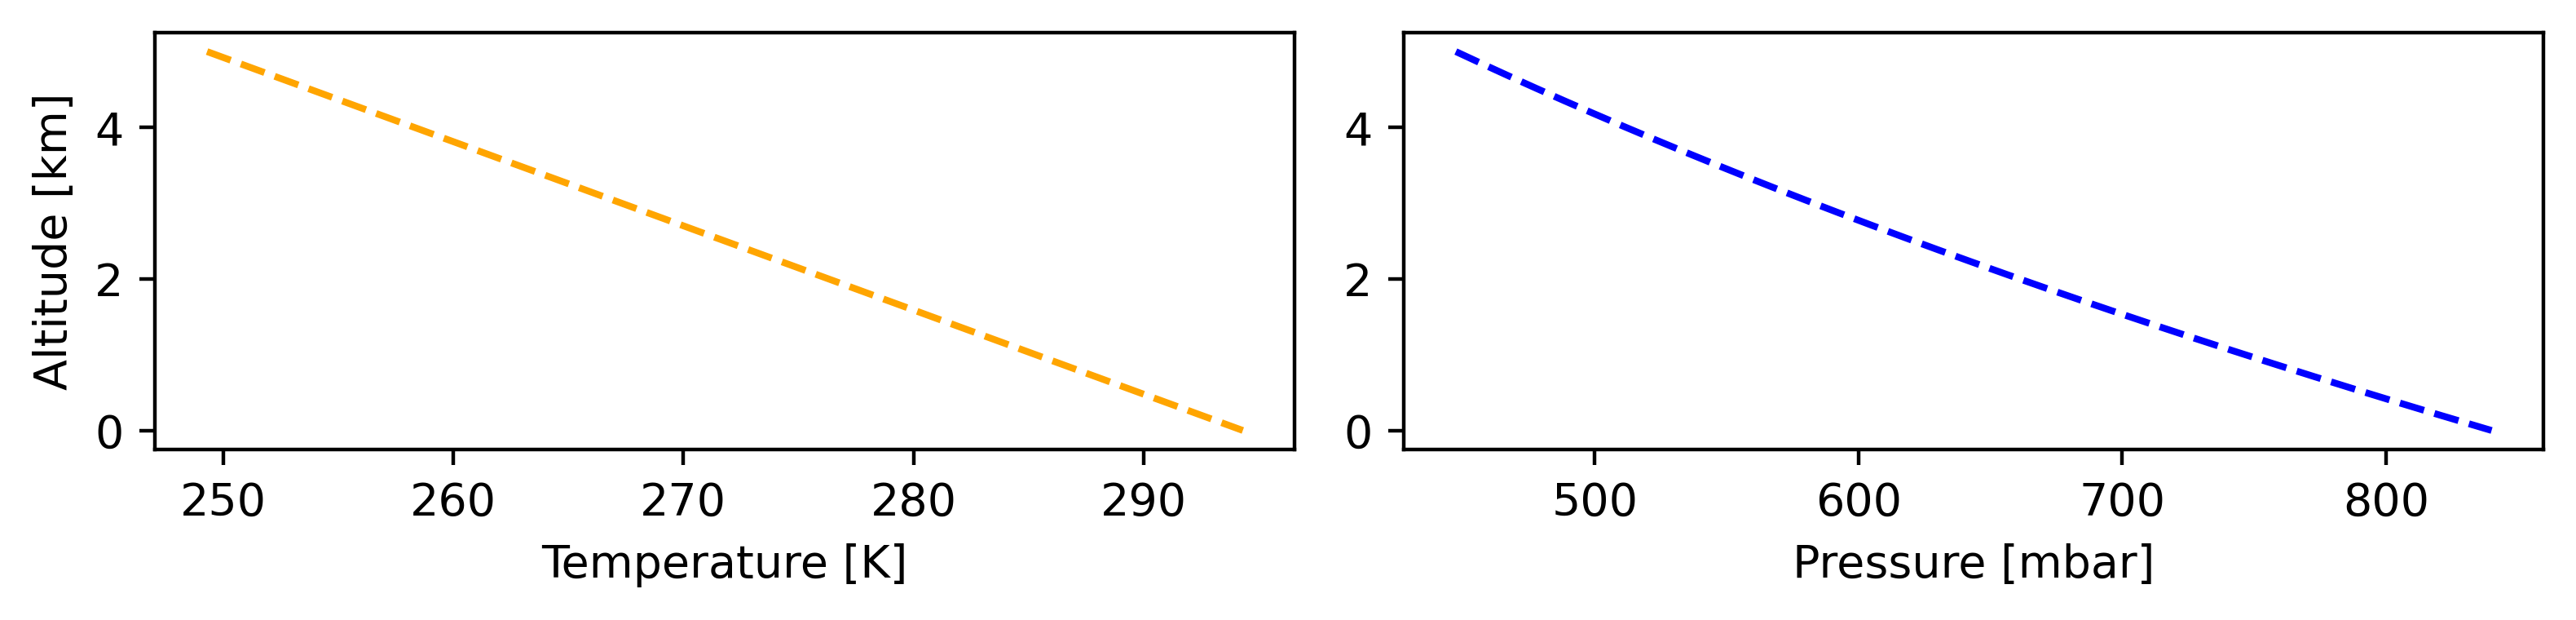

In [6]:
# Plot temperature and pressure profiles
fig = plt.figure(figsize=(8,2), dpi=400)
ax1 = fig.add_subplot(121)
ax1.plot(temp, alt/1e3, '--', color='orange')
ax1.set_ylabel('Altitude [km]')
ax1.set_xlabel('Temperature [K]')
ax2 = fig.add_subplot(122)
ax2.plot(pressure, alt/1e3, '--', color='blue')
ax2.set_xlabel('Pressure [mbar]')
plt.tight_layout()
plt.show()

In [48]:
# Generate extinction from molecular
trans = np.exp(-np.cumsum(alpha_mol*dR))

# Number of received photons per shot from molecular signal
N_mol = N_L*beta_mol*dR*A/R**2*trans**2*eta_sys*G_overlap + N_B
N_mol_col = np.sum(N_mol)

shots_hres_ABLE = hres_ABLE / sc_vel * f_L  # shots per targeted along-track resolution for ABLE
bins_vres_ABLE = (np.max(alt)-np.min(alt)) / vres_ABLE  # target bin number per column for ABLE

N_mol_col_int = N_mol_col * shots_hres_ABLE  # total photons per column after integrating horizontally
N_mol_bin = N_mol_col / bins_vres_ABLE  # photons per bin per shot (native)
N_mol_bin_int = N_mol_col_int / bins_vres_ABLE  # total photons per range bin after integrating horizontally 

print('\nUsing targeted ABLE specs...')
print('Photons (molecular signal) per')
print('\tIntegrated column: {:.2E}'.format(N_mol_col_int))
print('\tRange bin: {:.2E}'.format(N_mol_bin_int))

print('\nUsing native specs...')
print('Photons per')
print('\tSingle shot column: {:.2E}'.format(N_mol_col))
print('\tSingle shot bins: {:.2E}'.format(N_mol_bin))



Using targeted ABLE specs...
Photons (molecular signal) per
	Integrated column: 1.28E+04
	Range bin: 1.03E+03

Using native specs...
Photons per
	Single shot column: 2.06E+00
	Single shot bins: 1.65E-01


### TODO: Use HITRAN to generate more appropriate absorption coefficient values for water vapor

In [41]:
# Add cloud to signal

cloud_bot = 1.0e3  # [m] cloud base
cloud_top = 1.5e3  # [m] cloud top
cloud_alpha = 0.999  # sharp transition

plat_height = 0  # [m] Platform altitude
S_off = 20  # [sr] lidar ratio
# S = 40  # [sr] try this for rapid extinction
dtau_on_off = 1000  # typical tau difference for on/off wavelengths in cloud (vs 1 for outside cloud)
beta_aer_off = 5e-6  # [m-1 sr-1] singular value for aerosol backscatter
beta_aer_on = beta_aer_off  # [m-1 sr-1]
S_on = S_off * dtau_on_off  # [sr]

xsec = 1e-26  # [m^2]

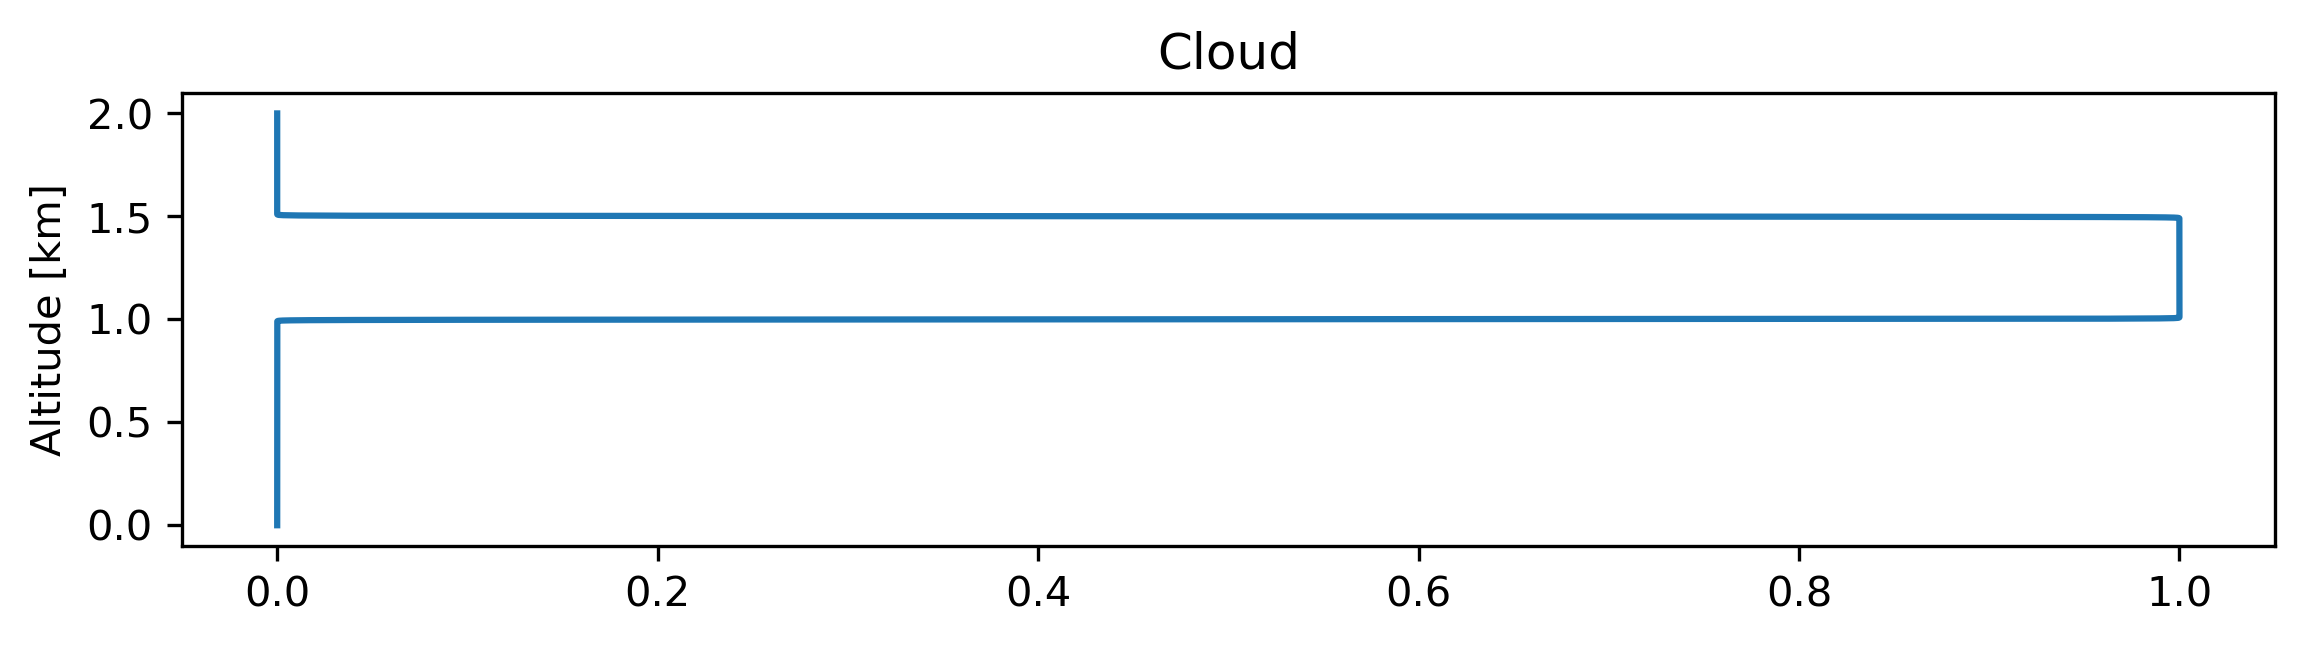

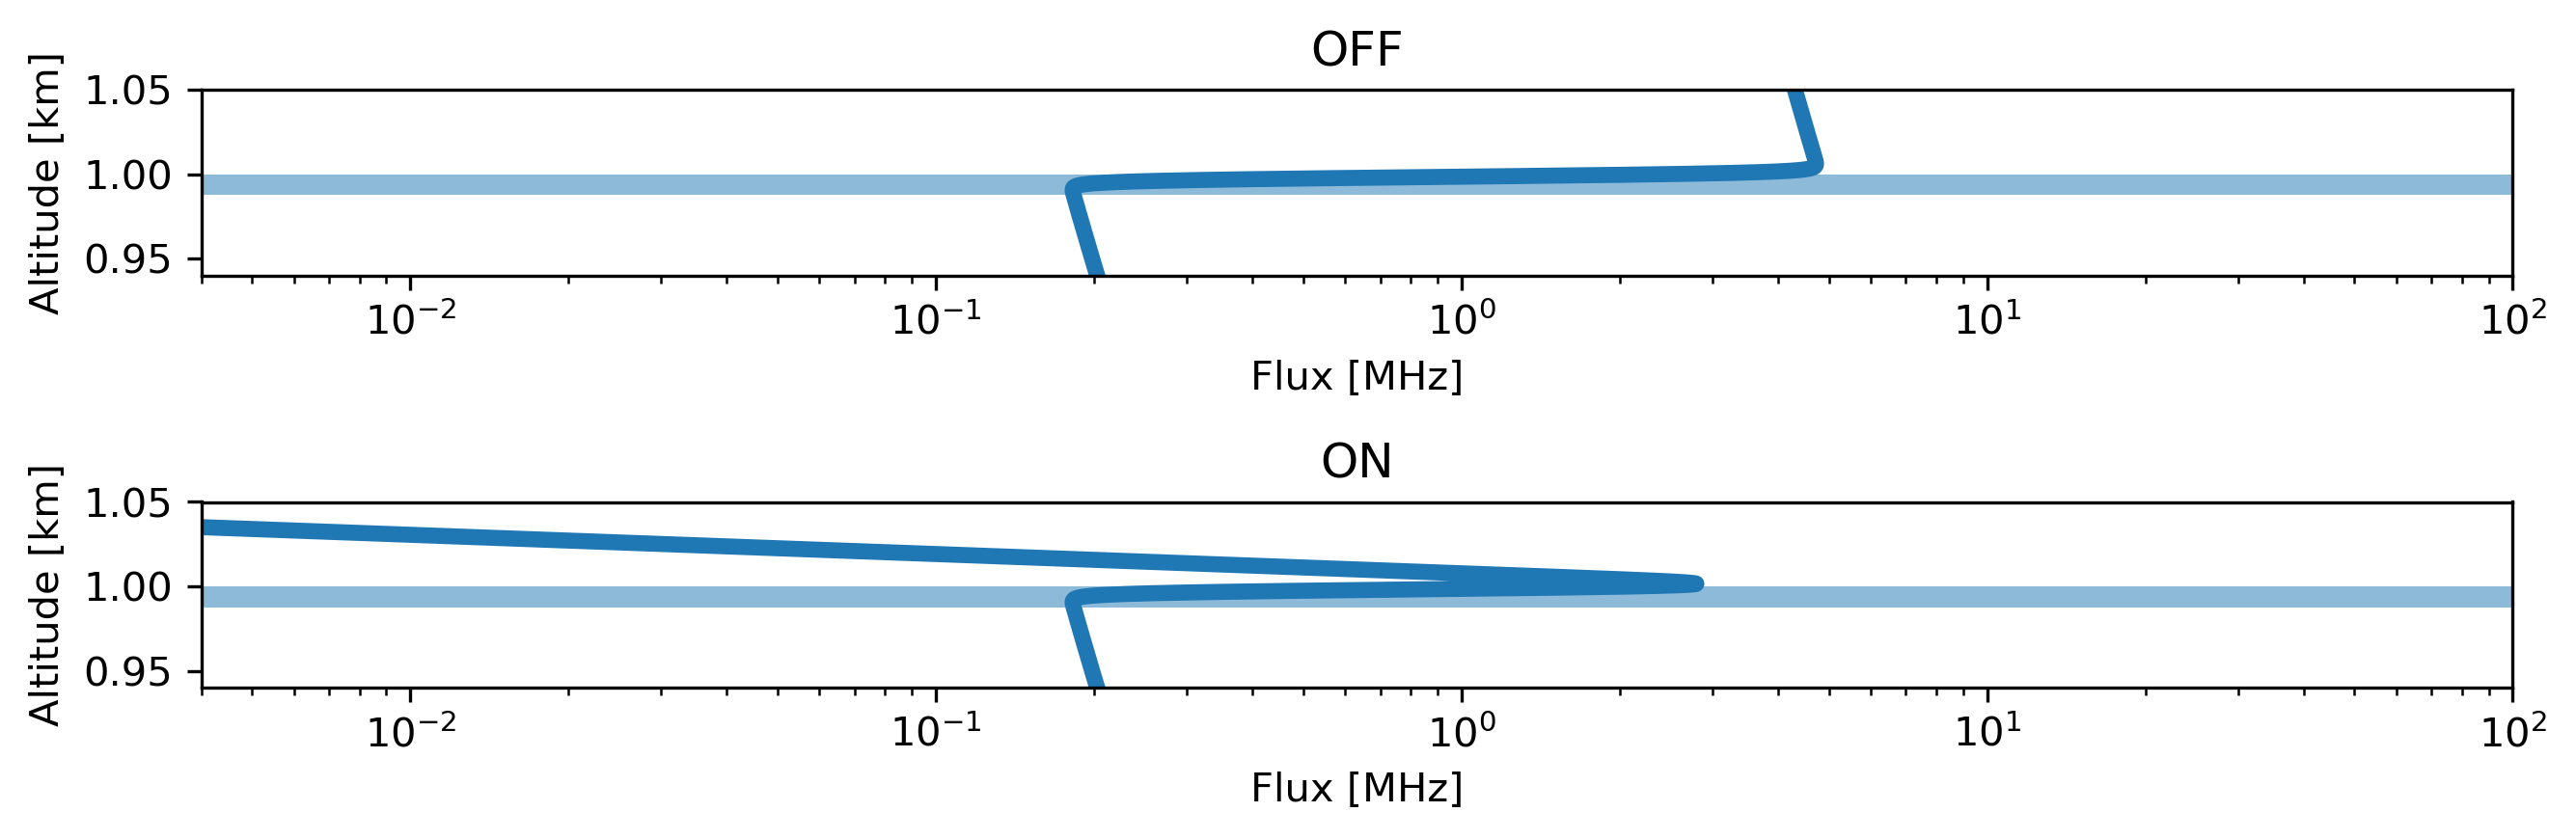

In [42]:
photon_rate_off, N_com_off, cloud = gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S_off, beta_aer_off, alpha_mol, beta_mol, N_L, A, eta*T_BS_HG, G, N_B, dt_TCSPC)
photon_rate_on, N_com_on, _ = gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S_on, beta_aer_on, alpha_mol, beta_mol, N_L, A, eta*T_BS_HG, G, N_B, dt_TCSPC)

# # Hack the signal to make it more in reasonable flux ranges...
# atten = 200
# photon_rate_off /= atten
# N_com_off /= atten
# photon_rate_on /= atten
# N_com_on /= atten

# Check cloud + mol signal

fig = plt.figure(figsize=(9, 2), dpi=300)
ax = fig.add_subplot(111)
ax.plot(cloud, alt/1e3)
ax.set_ylabel('Altitude [km]')
ax.set_title('Cloud')
plt.show()

fig = plt.figure(figsize=(9, 3), dpi=300)
ax1 = fig.add_subplot(211)
ax1.plot(photon_rate_off/1e6, R/1e3, '-', linewidth=4)
ax1.set_title('OFF')
ax1.set_ylabel('Altitude [km]')
ax1.set_xlabel('Flux [MHz]')
# ax1.set_title('Cloud Edge Backscatter')
ax1.set_xlim([4e-3, 1e2])
ax1.set_ylim([0.94, 1.05])
ax1.fill_between([4e-3, 3e3], 0.9875, 1.00, alpha=0.5)
ax1.set_xscale('log')
ax1 = fig.add_subplot(212)
ax1.plot(photon_rate_on/1e6, R/1e3, '-', linewidth=4)
ax1.set_title('ON')
ax1.set_ylabel('Altitude [km]')
ax1.set_xlabel('Flux [MHz]')
# ax1.set_title('Cloud Edge Backscatter')
ax1.set_xlim([4e-3, 1e2])
ax1.set_ylim([0.94, 1.05])
ax1.fill_between([4e-3, 3e3], 0.9875, 1.00, alpha=0.5)
ax1.set_xscale('log')
plt.tight_layout()
plt.show()

Offline Flux at Cloud Base: 4.723 MHz
Online Flux at Cloud Base: 2.797 MHz


C:\Users\Grant\AppData\Local\Temp\ipykernel_17168\1294256411.py:10: RuntimeWarning: invalid value encountered in divide
  true_conc = 1/2/xsec/dR*np.diff(np.log((phi_off)/(phi_on)))


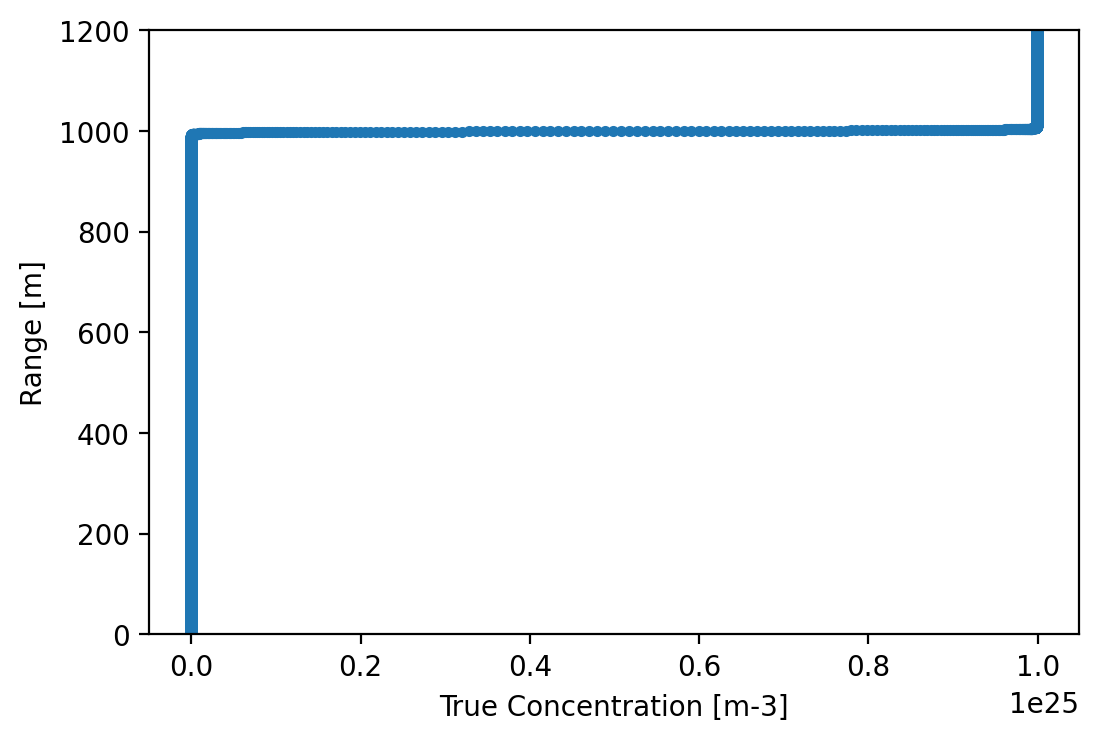

In [43]:
# tau_aim = 1  # Aiming for optical depth value of 1 
phi_off = photon_rate_off  # [Hz] offline flux
phi_on = photon_rate_on  # [Hz] online flux
# phi_on = phi_off_amp / bnp.e**(2*tau_aim)
# print('Ideal Optical Depth: {}'.format(tau_aim))
print('Offline Flux at Cloud Base: {:.3f} MHz'.format(np.max(phi_off)/1e6))
print('Online Flux at Cloud Base: {:.3f} MHz'.format(np.max(phi_on)/1e6))

dR = np.diff(R)[0]  # [m]
true_conc = 1/2/xsec/dR*np.diff(np.log((phi_off)/(phi_on)))

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(true_conc, (R[:-1]+dR/2), '.')
ax.set_xlabel('True Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_ylim([0, 1200])
# ax.set_xlim([-100, 1.5e20])
plt.show()

In [20]:
sim_num = 3

# Nshot = 14700 * 1
Nshot = 14700 * 5
print('{} shots'.format(Nshot))
print('{:.4f} sec of simulated data'.format(Nshot/f_L))

shift_bot = 950  # [m] what altitude to shift simulation axis to not plot anything below
shift_top = 1050  # [m] top as well
window_bnd = [shift_bot, shift_top]  # [m]
idx_bot_shift = np.argmin(np.abs(alt-shift_bot))
idx_top_shift = np.argmin(np.abs(alt-shift_top))
photon_rate_off_shift = photon_rate_off[idx_bot_shift:idx_top_shift]
photon_rate_on_shift = photon_rate_on[idx_bot_shift:idx_top_shift]

sim_time = alt / c * 2  # [s]
sim_time[0] = 0
sim_time = sim_time[idx_bot_shift:idx_top_shift+1]
sim_time -= np.min(sim_time)

t_res = dalt / c * 2  # [s]

73500 shots
5.0000 sec of simulated data


In [21]:
##### GENERATE SIMULATED DATA #####

# simulation resolution settings
if type(Nshot) != int:
    Nshot = int(Nshot)  # number of laser shots

wrap_deadtime = False

# generate photon counts

# lists of photon arrivals per laser shot
sync_idx = np.arange(Nshot)  # sync value
det_sync_idx = []
phot_sync_idx = []
det_events = []
phot_events = []

photon_rate_lst = [photon_rate_off_shift, photon_rate_on_shift]

for i in range(2):
    start = time.time()
    det_sync_idx_line = []
    phot_sync_idx_line = []
    det_events_line = []
    phot_events_line = []
    
    photon_rate = photon_rate_lst[i]  # [Hz]
    
    t_det_last = -100.0  # last photon detection event
    for n in range(Nshot):    
        # simulate a laser shot
        ptime, ctime = sim.photon_count_generator(sim_time, photon_rate, tau_d_flt=tD, last_photon_flt=t_det_last)
        if wrap_deadtime:
            if len(ctime) > 0:
                t_det_last = ctime[-1]
            t_det_last -= t_sim_bins[-1]

        ctime /= t_res  # convert from s to clock counts since sync event
        ptime /= t_res  # convert from s to clock counts since sync event

        for i in range(len(ctime)):
            det_events_line.append(ctime[i])  # detection time tags
            det_sync_idx_line.append(n)
        for i in range(len(ptime)):
            phot_events_line.append(ptime[i])  # photon time tags
            phot_sync_idx_line.append(n)

    print('Time elapsed: {} s'.format(time.time()-start))
    
    det_events.append(det_events_line)
    det_sync_idx.append(det_sync_idx_line)
    phot_events.append(phot_events_line)
    phot_sync_idx.append(phot_sync_idx_line)   

Time elapsed: 49.88747763633728 s
Time elapsed: 25.37639832496643 s


In [22]:
det_events_off = np.array(det_events[0])
det_sync_idx_off = np.array(det_sync_idx[0])
phot_events_off = np.array(phot_events[0])
phot_sync_idx_off = np.array(phot_sync_idx[0])
det_events_on = np.array(det_events[1])
det_sync_idx_on = np.array(det_sync_idx[1])
phot_events_on = np.array(phot_events[1])
phot_sync_idx_on = np.array(phot_sync_idx[1])

In [27]:
avg_range = 500
plot_bins = sim_time[::avg_range]  # [s]

n_det_off, bins = np.histogram(det_events_off*t_res, bins=plot_bins)
dt = np.diff(bins)[0]
det_flux_off = n_det_off/dt/Nshot

n_phot_off, _ = np.histogram(phot_events_off*t_res, bins=plot_bins)
phot_flux_off = n_phot_off/dt/Nshot

n_det_on, _ = np.histogram(det_events_on*t_res, bins=plot_bins)
det_flux_on = n_det_on/dt/Nshot

n_phot_on, _ = np.histogram(phot_events_on*t_res, bins=plot_bins)
phot_flux_on = n_phot_on/dt/Nshot

print('Plotting range resolution: {:.2f} m'.format(dt*c/2))

Plotting range resolution: 18.74 m


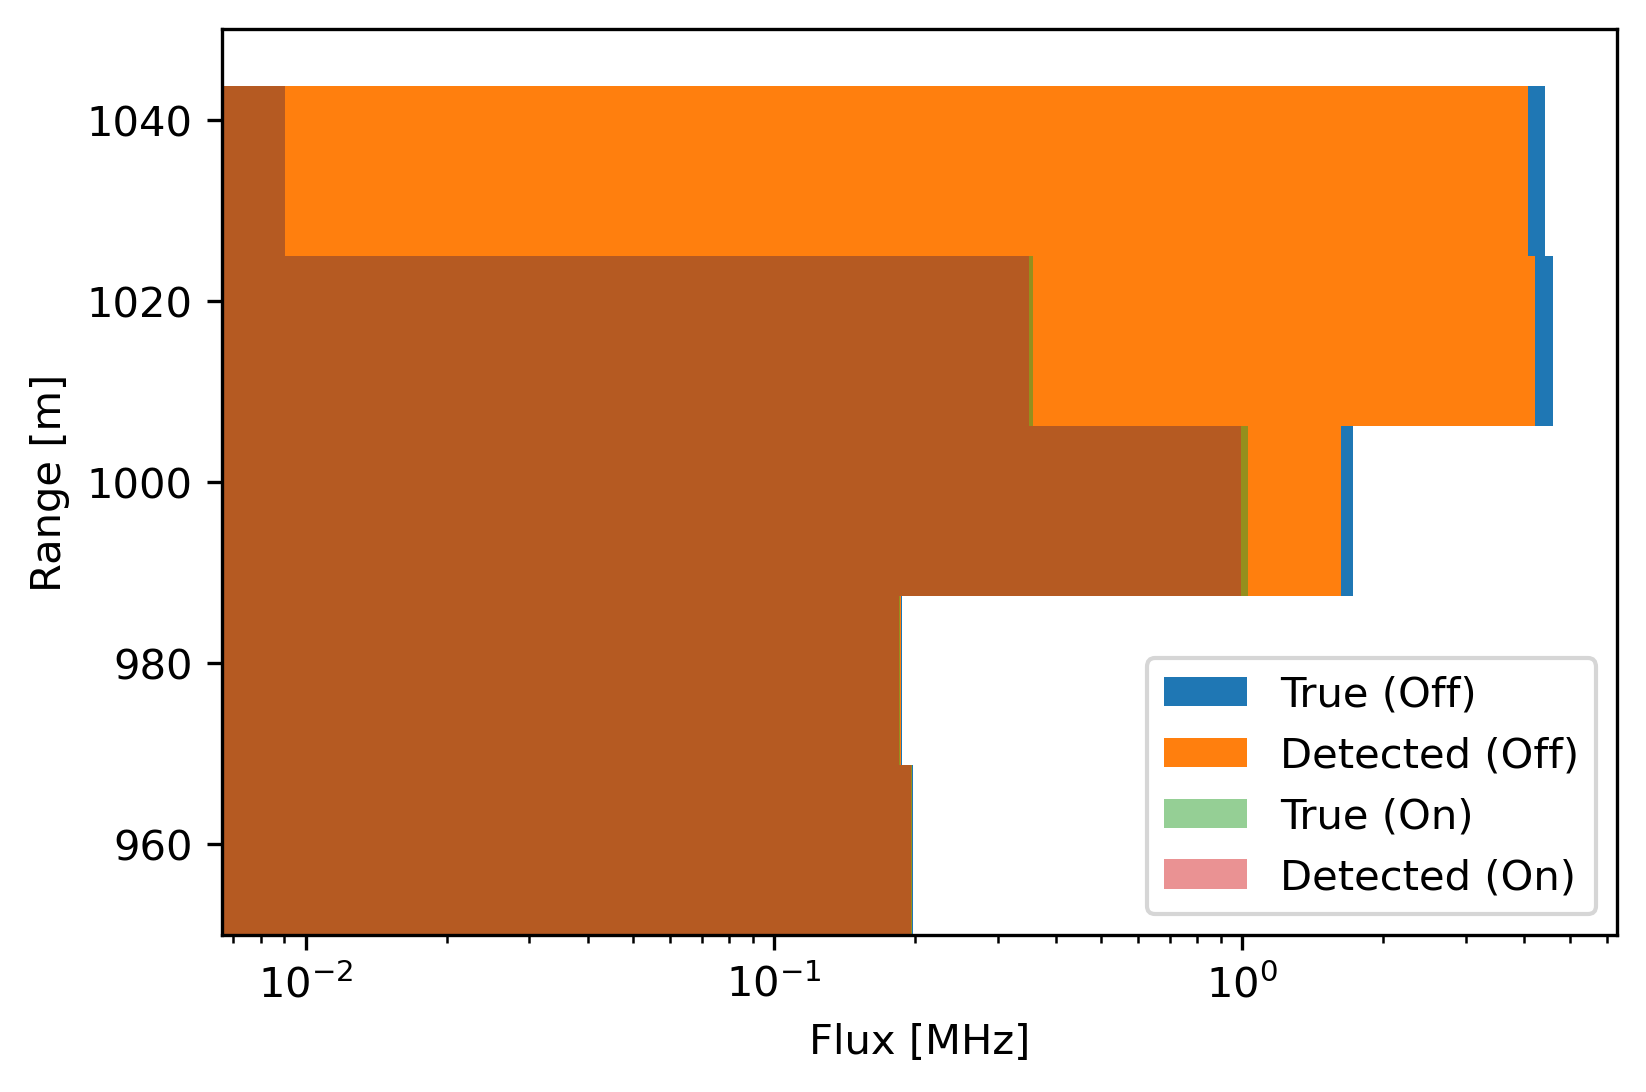

In [28]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, phot_flux_off/1e6, height=dt*c/2, label='True (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, det_flux_off/1e6, height=dt*c/2, label='Detected (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, phot_flux_on/1e6, height=dt*c/2, alpha=0.5, label='True (On)')
ax.barh((plot_bins[:-1]+dt/2)*c/2+shift_bot, det_flux_on/1e6, height=dt*c/2, alpha=0.5, label='Detected (On)')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_ylim([shift_bot, shift_top])
ax.set_xscale('log')
plt.legend()
plt.show()

In [29]:
dR_avg = dt * c / 2  # [m]
meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(det_flux_off/det_flux_on))  # [m-3]
muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((det_flux_off/(1-tD*det_flux_off))/(det_flux_on/(1-tD*det_flux_on))))  # [m-3]
true_conc = 1/2/xsec/dR_avg*np.diff(np.log((phi_off[idx_bot_shift:idx_top_shift][::avg_range])/(phi_on[idx_bot_shift:idx_top_shift][::avg_range])))

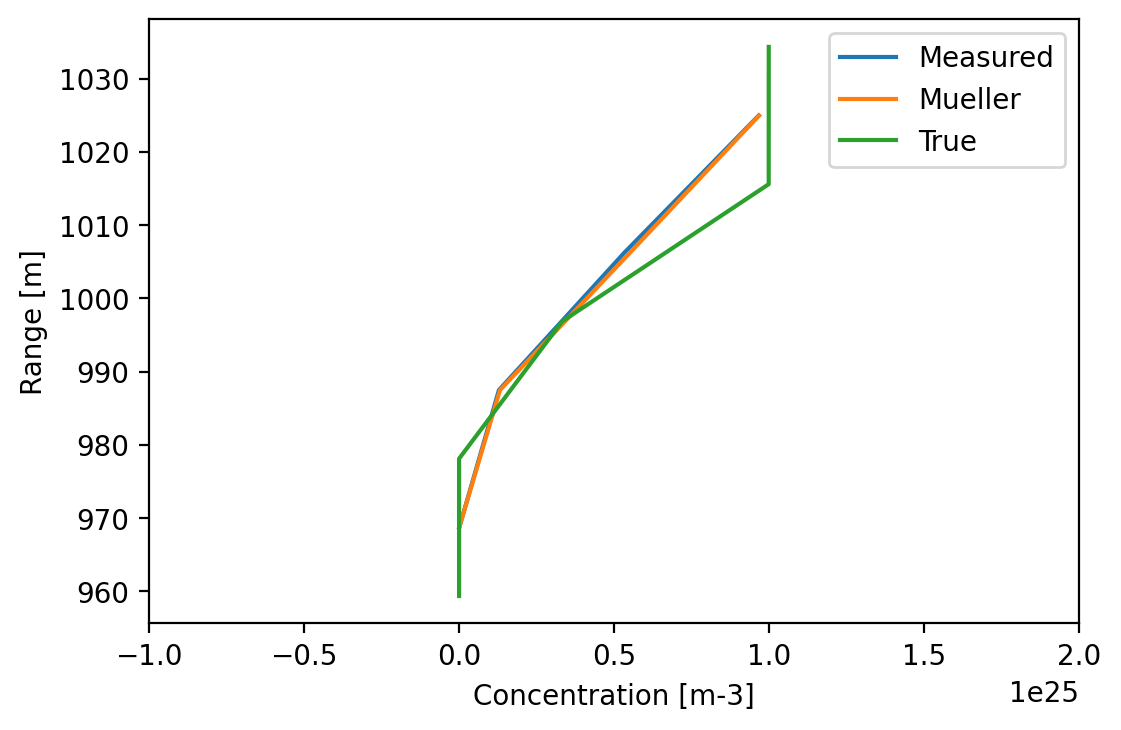

In [30]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(meas_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Measured')
ax.plot(muller_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Mueller')
ax.plot(true_conc, (plot_bins[:-1]+dt/2)*c/2+shift_bot, label='True')
ax.set_xlabel('Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_xlim([-1e25, 2e25])
# ax.set_ylim([980, 1020])
# ax.set_xscale('log')
plt.legend()
plt.show()

### Save data out then load to calculate active fraction and CDC and Mueller

In [19]:
home = str(Path.home())
save_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Cloud Measurements\Sims\saved_sims'

# Save data out
# OFFLINE
det_idx_off = np.arange(len(det_events_off))
phot_idx_off = np.arange(len(phot_events_off))
# ONLINE
det_idx_on = np.arange(len(det_events_on))
phot_idx_on = np.arange(len(phot_events_on))

# OFFLINE 
time_tag_index_off = det_idx_off
true_time_tag_index_off = phot_idx_off
sync_index = sync_idx
time_tag_off = det_events_off + shift_bot/c*2/t_res
true_time_tag_off = phot_events_off + shift_bot/c*2/t_res
time_tag_sync_index_off = det_sync_idx_off
true_time_tag_sync_index_off = phot_sync_idx_off
# ONLINE
time_tag_index_on = det_idx_on
true_time_tag_index_on = phot_idx_on
time_tag_on = det_events_on + shift_bot/c*2/t_res
true_time_tag_on = phot_events_on + shift_bot/c*2/t_res
time_tag_sync_index_on = det_sync_idx_on
true_time_tag_sync_index_on = phot_sync_idx_on

# Save simulated data to netCDF
sim_data_off = xr.Dataset(
    data_vars=dict(
        time_tag=(['time_tag_index'], time_tag_off),
        time_tag_sync_index=(['time_tag_index'], time_tag_sync_index_off),
        true_time_tag=(['true_time_tag_index'], true_time_tag_off),
        true_time_tag_sync_index=(['true_time_tag_index'], true_time_tag_sync_index_off),
        photon_rate_arr=photon_rate_off_shift,
        dt_sim=t_res,
        dtime=tD,
        t_sim_bins=sim_time,
        f_L = f_L,
        window_bnd = window_bnd
    ),
    coords=dict(
        sync_index=(['sync_index'], sync_index)
    )
)
sim_data_on = xr.Dataset(
    data_vars=dict(
        time_tag=(['time_tag_index'], time_tag_on),
        time_tag_sync_index=(['time_tag_index'], time_tag_sync_index_on),
        true_time_tag=(['true_time_tag_index'], true_time_tag_on),
        true_time_tag_sync_index=(['true_time_tag_index'], true_time_tag_sync_index_on),
        photon_rate_arr=photon_rate_on_shift,
        dt_sim=t_res,
        dtime=tD,
        t_sim_bins=sim_time,
        f_L = f_L,
        window_bnd = window_bnd
    ),
    coords=dict(
        sync_index=(['sync_index'], sync_index)
    )
)

fname_off = r'\simnum_{}_amp_{:.2E}off_nshot{:.2E}_OFF.nc'.format(sim_num, np.max(photon_rate_off_shift), Nshot)
sim_data_off.to_netcdf(save_dir+fname_off)

fname_on = r'\simnum_{}_amp_{:.2E}off_nshot{:.2E}_ON.nc'.format(sim_num, np.max(photon_rate_off_shift), Nshot)
sim_data_on.to_netcdf(save_dir+fname_on)

# Graveyard


In [ ]:
# def gen_cloud(alt, plat_height, cloud_bot, cloud_top, cloud_alpha, S, beta_aer, alpha_mol, beta_mol, dR, N_L, A, eta, G, N_B, dt):
# #     R = alt - plat_height  # [m] Remove platform height to convert to range
    
# #     cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))
# #     cloud = np.ones(len(alt))
# #     cloud *= cloud_sig
    
# #     beta_aer *= cloud  # [m-1 sr-1]
# #     alpha_aer = S * beta_aer
        
# #     trans = np.exp(-np.cumsum((alpha_mol+alpha_aer)*dR))
# #     N_com = N_L*(beta_mol + beta_aer)*dR*A/R**2*trans**2*eta*G + N_B
# #     N_com[0] = 0

# #     rho_func = N_com / dt  # [Hz]
# #     photon_rate = rho_func  # [Hz]
   
# #     return photon_rate, N_com, cloud